<a href="https://colab.research.google.com/github/congltk1234/HM_Fashion_Recommendation/blob/main/Notebook/model/EmbeddingsEffb0_KNN_CosineSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

>[Load data](#scrollTo=XGYr4zQCJwKr)

>[Embedding Image](#scrollTo=fgAXmuzKKU60)

>>[KNN training](#scrollTo=SXW4eDGez1z9)

>[Results](#scrollTo=HyVuJ808zqJ4)



# Load data

In [ ]:
!gdown 1aFgQ7kBRf9gUpGSKIDc0DrjG6AGwnkYN
# https://drive.google.com/file/d/1aFgQ7kBRf9gUpGSKIDc0DrjG6AGwnkYN/view?usp=sharing
!unzip "/content/drive/MyDrive/HM/HM_images_256x256.zip" -d "/content"

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1aFgQ7kBRf9gUpGSKIDc0DrjG6AGwnkYN 

Archive:  /content/drive/MyDrive/HM/HM_images_256x256.zip
replace /content/images_256_256/012/0123173001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
n


In [ ]:
!gdown 129p_LXa2JUPhBZj-fNhGYvQeNrWxKhJo
!unzip "/content/VN-celeb.zip" -d "/content"

In [ ]:
import os
import pandas as pd

def get_article_images_df(path='images_256_256'):
    article_ids = []
    image_paths = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_path = fullpath
            article_id = fullpath.split('/')[-1].replace('.jpg', '')
            article_ids.append(article_id)
            image_paths.append(fullpath)
    return pd.DataFrame({'article_id': article_ids, 'image': image_paths})

In [ ]:
df = get_article_images_df()
df.head()

,article_id,image
0,0108775051,images_256_256/010/0108775051.jpg
1,0108775015,images_256_256/010/0108775015.jpg
2,0108775044,images_256_256/010/0108775044.jpg
3,0766921003,images_256_256/076/0766921003.jpg
4,0760633001,images_256_256/076/0760633001.jpg


In [ ]:
import cv2
import numpy as np
import tensorflow as tf


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32):
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.df))

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(((len(self.df)) % self.batch_size) != 0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X = self.__data_generation(indexes)
        return X

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'
        X = np.zeros((len(indexes), self.img_size, self.img_size, 3), dtype='float32')
        df = self.df.iloc[indexes]
        for i, (index, row) in enumerate(df.iterrows()):
            img = cv2.imread(row.image)
            X[i,] = cv2.resize(img, (self.img_size, self.img_size))  # /128.0 - 1.0
        return X

# Embedding Image

In [ ]:
#@title Load model
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)
train_gen = DataGenerator(df, batch_size=32)
image_embeddings = model.predict(train_gen, verbose=1)

3285/3285 [==============================] - 9807s 3s/step


In [ ]:
# Stored embbed feature
with open('hm_embeddings_effb0.npy', 'wb') as f:
    np.save(f, image_embeddings)

!cp /content/hm_embeddings_effb0.npy /content/drive/MyDrive/HM/HM_Features/hm_embeddings_effb0.npy


image_embeddings.shape

## KNN training


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
image_embeddings = np.load('/content/drive/MyDrive/HM/HM_Features/hm_embeddings_effb0.npy')

In [ ]:
from sklearn.neighbors import NearestNeighbors
print('image embeddings shape is', image_embeddings.shape)
KNN = 12
knn = NearestNeighbors(n_neighbors=KNN)
knn.fit(image_embeddings)

image embeddings shape is (105100, 1280)


NearestNeighbors(n_neighbors=12)

In [ ]:
from joblib import dump, load
dump(knn, 'knn.joblib')

['knn.joblib']

# Results


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import joblib

df_articles = pd.read_csv('/content/drive/MyDrive/HM/articles.csv')
knn = joblib.load('/content/knn.joblib')

In [ ]:
df.shape
105542

(105100, 2)

In [ ]:
df = get_article_images_df()
df['article_id'] = df['article_id'].astype('int64')
df.head()

,article_id,image
0,108775051,images_256_256/010/0108775051.jpg
1,108775015,images_256_256/010/0108775015.jpg
2,108775044,images_256_256/010/0108775044.jpg
3,766921003,images_256_256/076/0766921003.jpg
4,760633001,images_256_256/076/0760633001.jpg


In [ ]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pandasql import sqldf
df_a = sqldf("""SELECT article_id, prod_name, product_type_name, product_group_name, colour_group_name, index_name
            FROM df_articles
            """)
df_a

,article_id,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,108775015,Strap top,Vest top,Garment Upper body,Black,Ladieswear
1,108775044,Strap top,Vest top,Garment Upper body,White,Ladieswear
2,108775051,Strap top (1),Vest top,Garment Upper body,Off White,Ladieswear
3,110065001,OP T-shirt (Idro),Bra,Underwear,Black,Lingeries/Tights
4,110065002,OP T-shirt (Idro),Bra,Underwear,White,Lingeries/Tights
...,...,...,...,...,...,...
105537,953450001,5pk regular Placement1,Socks,Socks & Tights,Black,Menswear
105538,953763001,SPORT Malaga tank,Vest top,Garment Upper body,Black,Ladieswear
105539,956217002,Cartwheel dress,Dress,Garment Full body,Black,Ladieswear
105540,957375001,CLAIRE HAIR CLAW,Hair clip,Accessories,Black,Divided


In [ ]:
result = pd.merge(df, df_a, on="article_id")
result

,article_id,image,prod_name,product_type_name,product_group_name,colour_group_name,index_name
0,108775051,images_256_256/010/0108775051.jpg,Strap top (1),Vest top,Garment Upper body,Off White,Ladieswear
1,108775015,images_256_256/010/0108775015.jpg,Strap top,Vest top,Garment Upper body,Black,Ladieswear
2,108775044,images_256_256/010/0108775044.jpg,Strap top,Vest top,Garment Upper body,White,Ladieswear
3,766921003,images_256_256/076/0766921003.jpg,Lowri hood,Sweater,Garment Upper body,Light Pink,Children Sizes 134-170
4,760633001,images_256_256/076/0760633001.jpg,Coin HW tapered,Trousers,Garment Lower body,Greenish Khaki,Ladieswear
...,...,...,...,...,...,...,...
105095,614422001,images_256_256/061/0614422001.jpg,BYN Meet the parents,Dress,Garment Full body,Light Purple,Ladieswear
105096,617734001,images_256_256/061/0617734001.jpg,DIV Karenia biker jkt,Jacket,Garment Upper body,Grey,Divided
105097,611469002,images_256_256/061/0611469002.jpg,zimmer dress,Dress,Garment Full body,Red,Divided
105098,617590002,images_256_256/061/0617590002.jpg,wayne knit,Sweater,Garment Upper body,Light Grey,Menswear


In [ ]:
#@title Compute Cosine Similarity
import cv2
import matplotlib.pyplot as plt

def compute_distances(df, idx, model, knn):
    """
    Returns distances indices of most similar products based on embeddings extracted from model
    """
    X = np.zeros((1, 256, 256, 3), dtype='float32')
    img = cv2.imread(df.iloc[idx].image)    # TODO: cv2.readfrombinary
    img = cv2.resize(img, (256, 256))
    input_show(img)
    X[0,] = img
    model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)
    inf_embeddings = model.predict(X, verbose=1)
    distances, indices = knn.kneighbors(inf_embeddings)
    return distances, indices

def input_show(data):
    im_bgr = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
    plt.title("Query Image")
    plt.imshow(im_bgr)

def plot_results(df, indices, distances, col_size=3, row_size=4):

    fig, axs = plt.subplots(col_size, row_size, figsize=(20, 15))
    axs = axs.flatten()
    i = 0
    for ax, idx in zip(axs, indices[0]):
        if i == 0: 
            ax.set_title(f'Query image \n {df.iloc[idx].prod_name} \n {df.iloc[idx].product_type_name},{df.iloc[idx].product_group_name}',  color= 'red', fontweight='bold')
        else: 
            # ax.set_title(f'{i} most similar')
            ax.set_title(f'Product ID: {df.iloc[idx].article_id} \n {df.iloc[idx].prod_name} \n {df.iloc[idx].product_type_name},{df.iloc[idx].product_group_name}')
        img = cv2.imread(df.iloc[idx].image)
        #img = cv2.resize(img, (256, 256))
        im_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        ax.axis('off')
        ax.imshow(im_bgr, aspect='auto')
        i+=1
    fig.suptitle('Similar products', fontsize=36)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)

1/1 [==============================] - 2s 2s/step


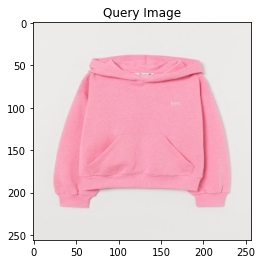

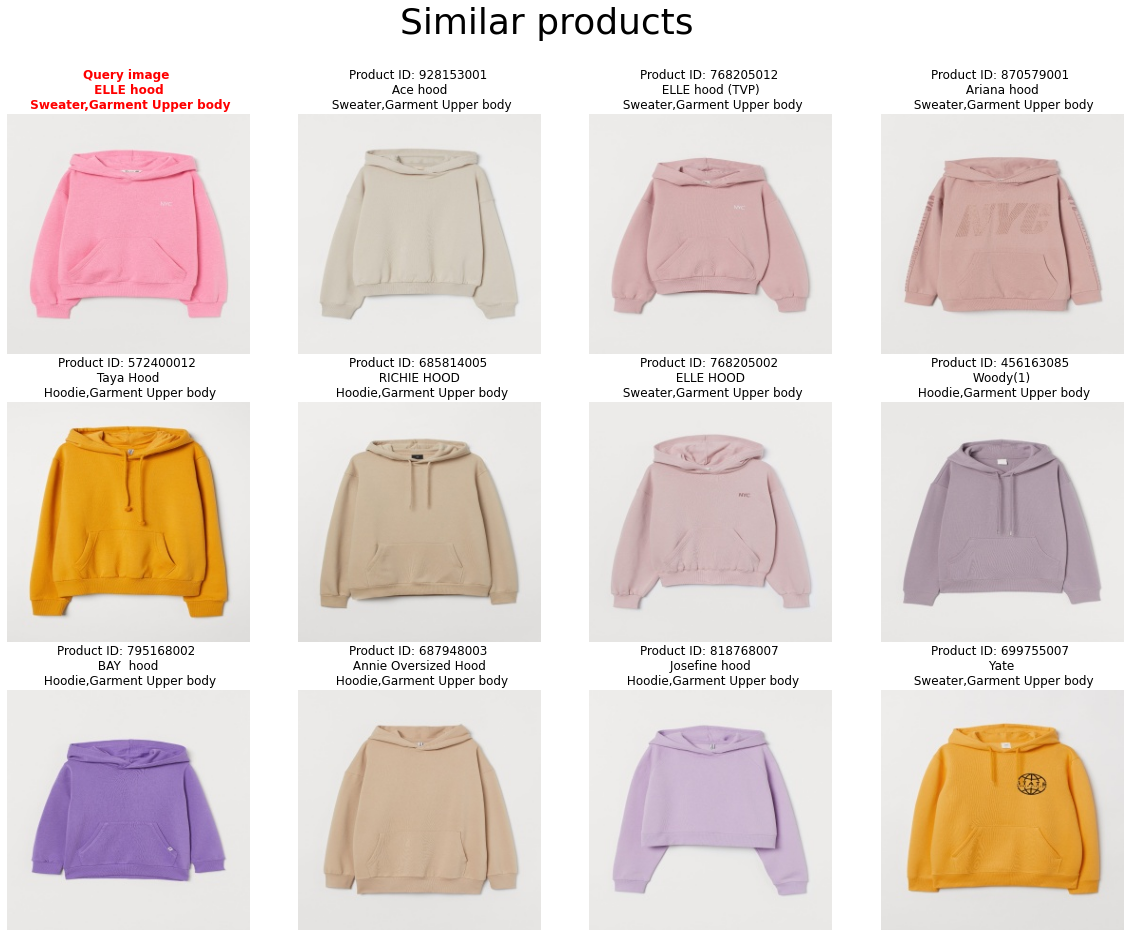

In [ ]:
distances, indices = compute_distances(result, 7, model, knn)
plot_results(result, indices, distances)

1/1 [==============================] - 3s 3s/step


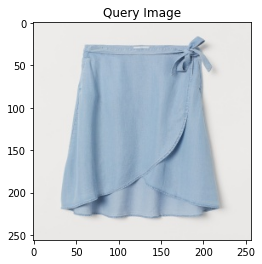

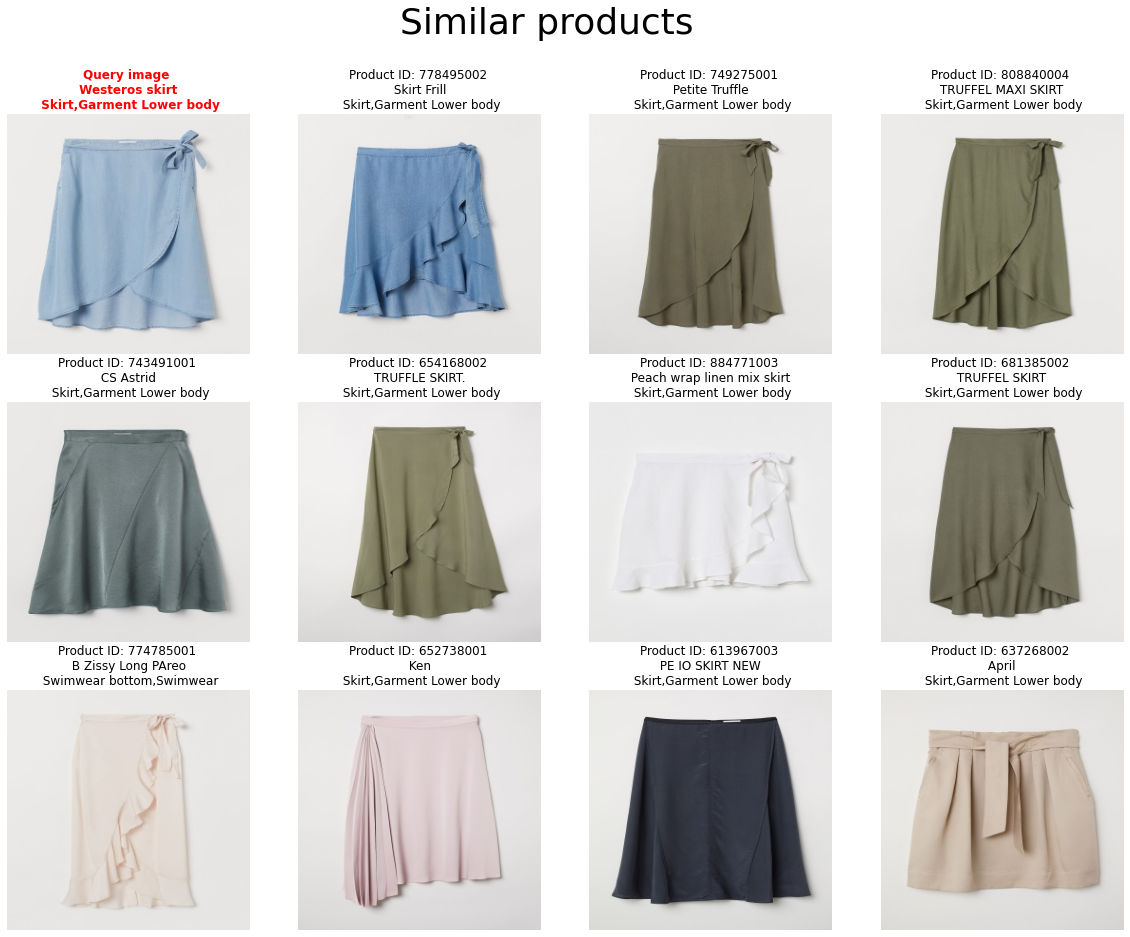

In [ ]:
distances, indices = compute_distances(result, 999, model, knn)
plot_results(result, indices, distances)

Reference
- https://www.kaggle.com/code/joelqv/h-m-product-similarity-1-embeddings-knn/notebook
- https://www.kaggle.com/code/joelqv/h-m-product-similarity-2-results

